# 03 — Discordant Gene Characterization

Characterize genes where FBA predictions and growth measurements disagree:
- **FBA-essential + growth-normal**: FBA over-predicts importance
- **FBA-blocked + growth-defect**: FBA under-predicts importance

Analyses:
1. COG category enrichment (Fisher's exact test)
2. Pangenome status (core vs accessory)
3. Functional annotation and pathway clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
from pathlib import Path

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 150

DATA_DIR = Path('../data')
FIG_DIR = Path('../figures')

triple = pd.read_csv(DATA_DIR / 'triple_gene_table.csv')
print(f'Loaded {len(triple)} genes')

Loaded 478 genes


## 1. Define Discordance Classes

In [2]:
# Define concordance/discordance classes
# Concordant: FBA-essential + growth-defect, FBA-blocked + growth-normal
# Discordant: FBA-essential + growth-normal (over-predict), FBA-blocked + growth-defect (under-predict)
# Variable: FBA-variable (ambiguous, not clearly concordant/discordant)

def classify_discord(row):
    fba = row['minimal_media_class']
    growth = row['any_growth_defect']
    if fba == 'essential' and growth:
        return 'concordant_essential'
    elif fba == 'essential' and not growth:
        return 'discordant_over'
    elif fba == 'blocked' and not growth:
        return 'concordant_blocked'
    elif fba == 'blocked' and growth:
        return 'discordant_under'
    elif fba == 'variable' and growth:
        return 'variable_defect'
    elif fba == 'variable' and not growth:
        return 'variable_normal'
    return 'other'

triple['discord_class'] = triple.apply(classify_discord, axis=1)

print('Discordance classes:')
class_counts = triple['discord_class'].value_counts()
for cls, n in class_counts.items():
    print(f'  {cls:<25} {n:>4} ({n/len(triple)*100:5.1f}%)')

# For enrichment analysis, compare discordant vs concordant+variable
triple['is_discordant'] = triple['discord_class'].isin(['discordant_over', 'discordant_under'])
print(f'\nTotal discordant: {triple["is_discordant"].sum()}')

Discordance classes:
  variable_defect            150 ( 31.4%)
  discordant_under           136 ( 28.5%)
  concordant_blocked          60 ( 12.6%)
  concordant_essential        57 ( 11.9%)
  variable_normal             54 ( 11.3%)
  discordant_over             21 (  4.4%)

Total discordant: 157


## 2. RAST Function Enrichment

Test whether discordant genes are enriched in specific functional categories.
We use RAST function annotations (100% coverage) instead of COG identifiers
(which are COG IDs like `COG0189`, not functional category letters, and only
cover 13% of genes).

In [3]:
# Group RAST functions into broader categories for enrichment
# Extract functional keywords from RAST annotations
def categorize_rast(func):
    """Assign a broad functional category based on RAST annotation keywords."""
    if pd.isna(func):
        return 'Unknown'
    func_lower = func.lower()
    if any(k in func_lower for k in ['ribosom', 'trna', 'rrna', 'translation']):
        return 'Translation'
    if any(k in func_lower for k in ['transporter', 'permease', 'abc transport', 'symporter',
                                      'antiporter', 'efflux', 'porin']):
        return 'Transport'
    if any(k in func_lower for k in ['transcription', 'sigma factor', 'regulator',
                                      'repressor', 'activator', 'response regulator']):
        return 'Transcription/Regulation'
    if any(k in func_lower for k in ['lipid', 'fatty acid', 'acyl', 'phospholipid',
                                      'cardiolipin', 'lipase']):
        return 'Lipid metabolism'
    if any(k in func_lower for k in ['amino acid', 'aminotransferase', 'peptidase',
                                      'protease', 'aminoacyl']):
        return 'Amino acid metabolism'
    if any(k in func_lower for k in ['nucleotide', 'purine', 'pyrimidine', 'nucleoside',
                                      'phosphoribosyl']):
        return 'Nucleotide metabolism'
    if any(k in func_lower for k in ['dehydrogenase', 'oxidase', 'reductase', 'cytochrome',
                                      'electron transfer', 'nadh', 'succinate']):
        return 'Energy/Redox'
    if any(k in func_lower for k in ['cell wall', 'peptidoglycan', 'murein', 'lipopolysaccharide',
                                      'undecaprenyl', 'transpeptidase']):
        return 'Cell wall/membrane'
    if any(k in func_lower for k in ['chaperone', 'heat shock', 'protease', 'folding']):
        return 'Protein quality control'
    if any(k in func_lower for k in ['dna', 'replication', 'recombination', 'repair',
                                      'gyrase', 'helicase', 'topoisomerase']):
        return 'DNA maintenance'
    if any(k in func_lower for k in ['aromatic', 'benzoate', 'catechol', 'protocatechuate',
                                      'hydroxybenzoate', 'carboxymuconolactone', 'ketoadipate',
                                      'quinate', 'phenylacet']):
        return 'Aromatic degradation'
    if any(k in func_lower for k in ['sulfon', 'sulfat', 'sulfur', 'thio']):
        return 'Sulfur metabolism'
    if any(k in func_lower for k in ['iron', 'zinc', 'copper', 'manganese', 'cobalt',
                                      'siderophore']):
        return 'Metal homeostasis'
    if any(k in func_lower for k in ['acetyltransferase', 'methyltransferase',
                                      'kinase', 'phosphatase']):
        return 'Modification enzymes'
    if any(k in func_lower for k in ['hypothetical', 'unknown', 'uncharacterized',
                                      'domain of unknown']):
        return 'Hypothetical'
    return 'Other metabolism'

triple['rast_category'] = triple['rast_function'].apply(categorize_rast)

print('RAST functional category distribution:')
cat_counts = triple['rast_category'].value_counts()
for cat, n in cat_counts.items():
    print(f'  {cat:<30} {n:>4} ({n/len(triple)*100:5.1f}%)')

RAST functional category distribution:
  Other metabolism                152 ( 31.8%)
  Energy/Redox                     92 ( 19.2%)
  Transport                        76 ( 15.9%)
  Lipid metabolism                 46 (  9.6%)
  Modification enzymes             35 (  7.3%)
  Amino acid metabolism            19 (  4.0%)
  Sulfur metabolism                15 (  3.1%)
  Nucleotide metabolism            12 (  2.5%)
  Aromatic degradation             11 (  2.3%)
  Metal homeostasis                 8 (  1.7%)
  Translation                       7 (  1.5%)
  Cell wall/membrane                3 (  0.6%)
  DNA maintenance                   2 (  0.4%)


In [4]:
# Fisher's exact test for each RAST functional category:
# Compare discordant vs non-discordant genes
from statsmodels.stats.multitest import multipletests

enrichment_results = []
all_categories = triple['rast_category'].unique()

for cat in sorted(all_categories):
    has_cat = triple['rast_category'] == cat
    a = (triple['is_discordant'] & has_cat).sum()
    b = (triple['is_discordant'] & ~has_cat).sum()
    c = (~triple['is_discordant'] & has_cat).sum()
    d = (~triple['is_discordant'] & ~has_cat).sum()

    if a + c >= 5:  # minimum 5 genes in category
        odds, p = stats.fisher_exact([[a, b], [c, d]])
        enrichment_results.append({
            'category': cat,
            'discordant': a,
            'concordant': c,
            'total': a + c,
            'odds_ratio': odds,
            'p_value': p,
        })

enrich_df = pd.DataFrame(enrichment_results).sort_values('p_value')
reject, pvals_corr, _, _ = multipletests(enrich_df['p_value'], method='fdr_bh')
enrich_df['q_value'] = pvals_corr
enrich_df['significant'] = reject

print('RAST functional category enrichment in discordant genes (Fisher exact, BH-FDR):')
display(enrich_df.round(4))

RAST functional category enrichment in discordant genes (Fisher exact, BH-FDR):


,category,discordant,concordant,total,odds_ratio,p_value,q_value,significant
1,Aromatic degradation,9,2,11,9.6993,0.0011,0.0118,True
3,Lipid metabolism,7,39,46,0.3374,0.0077,0.0421,True
5,Modification enzymes,17,18,35,2.0440,0.0597,0.2191,False
9,Translation,0,7,7,0.0000,0.1016,0.2794,False
7,Other metabolism,56,96,152,1.2995,0.2110,0.4434,False
8,Sulfur metabolism,7,8,15,1.8258,0.2698,0.4434,False
4,Metal homeostasis,1,7,8,0.2875,0.2822,0.4434,False
0,Amino acid metabolism,4,15,19,0.5333,0.3259,0.4482,False
2,Energy/Redox,27,65,92,0.8180,0.4605,0.5629,False
10,Transport,23,53,76,0.8679,0.6899,0.7586,False


In [5]:
# Enrichment by discordance direction
for disc_type, label in [('discordant_over', 'FBA over-predicts (essential+normal)'),
                          ('discordant_under', 'FBA under-predicts (blocked+defect)')]:
    disc_mask = triple['discord_class'] == disc_type
    results = []
    for cat in sorted(all_categories):
        has_cat = triple['rast_category'] == cat
        a = (disc_mask & has_cat).sum()
        b = (disc_mask & ~has_cat).sum()
        c = (~disc_mask & has_cat).sum()
        d = (~disc_mask & ~has_cat).sum()
        if a + c >= 5:
            odds, p = stats.fisher_exact([[a, b], [c, d]])
            results.append({
                'category': cat,
                'in_class': a,
                'total': a + c,
                'odds_ratio': odds,
                'p_value': p
            })
    rdf = pd.DataFrame(results).sort_values('p_value')
    if len(rdf) > 0:
        reject_dir, pvals_dir, _, _ = multipletests(rdf['p_value'], method='fdr_bh')
        rdf['q_value'] = pvals_dir
    print(f'\n{label} (n={disc_mask.sum()}):')
    display(rdf.head(10).round(4))


FBA over-predicts (essential+normal) (n=21):


,category,in_class,total,odds_ratio,p_value,q_value
0,Amino acid metabolism,3,19,4.5938,0.0450,0.4948
2,Energy/Redox,1,92,0.2011,0.0950,0.5226
5,Modification enzymes,3,35,2.2135,0.1928,0.6550
7,Other metabolism,4,152,0.4913,0.2382,0.6550
6,Nucleotide metabolism,1,12,2.0273,0.4205,0.8110
3,Lipid metabolism,3,46,1.6047,0.4423,0.8110
1,Aromatic degradation,0,11,0.0000,1.0000,1.0000
4,Metal homeostasis,0,8,0.0000,1.0000,1.0000
8,Sulfur metabolism,0,15,0.0000,1.0000,1.0000
9,Translation,0,7,0.0000,1.0000,1.0000



FBA under-predicts (blocked+defect) (n=136):


,category,in_class,total,odds_ratio,p_value,q_value
1,Aromatic degradation,9,11,12.0472,0.0003,0.0035
3,Lipid metabolism,4,46,0.2165,0.0010,0.0054
0,Amino acid metabolism,1,19,0.1333,0.0192,0.0706
7,Other metabolism,52,152,1.4981,0.0644,0.1770
5,Modification enzymes,14,35,1.7541,0.1225,0.2636
8,Sulfur metabolism,7,15,2.2655,0.1438,0.2636
9,Translation,0,7,0.0000,0.1995,0.3136
4,Metal homeostasis,1,8,0.3545,0.4501,0.6188
6,Nucleotide metabolism,2,12,0.4955,0.5228,0.6390
10,Transport,20,76,0.8805,0.7817,0.8598


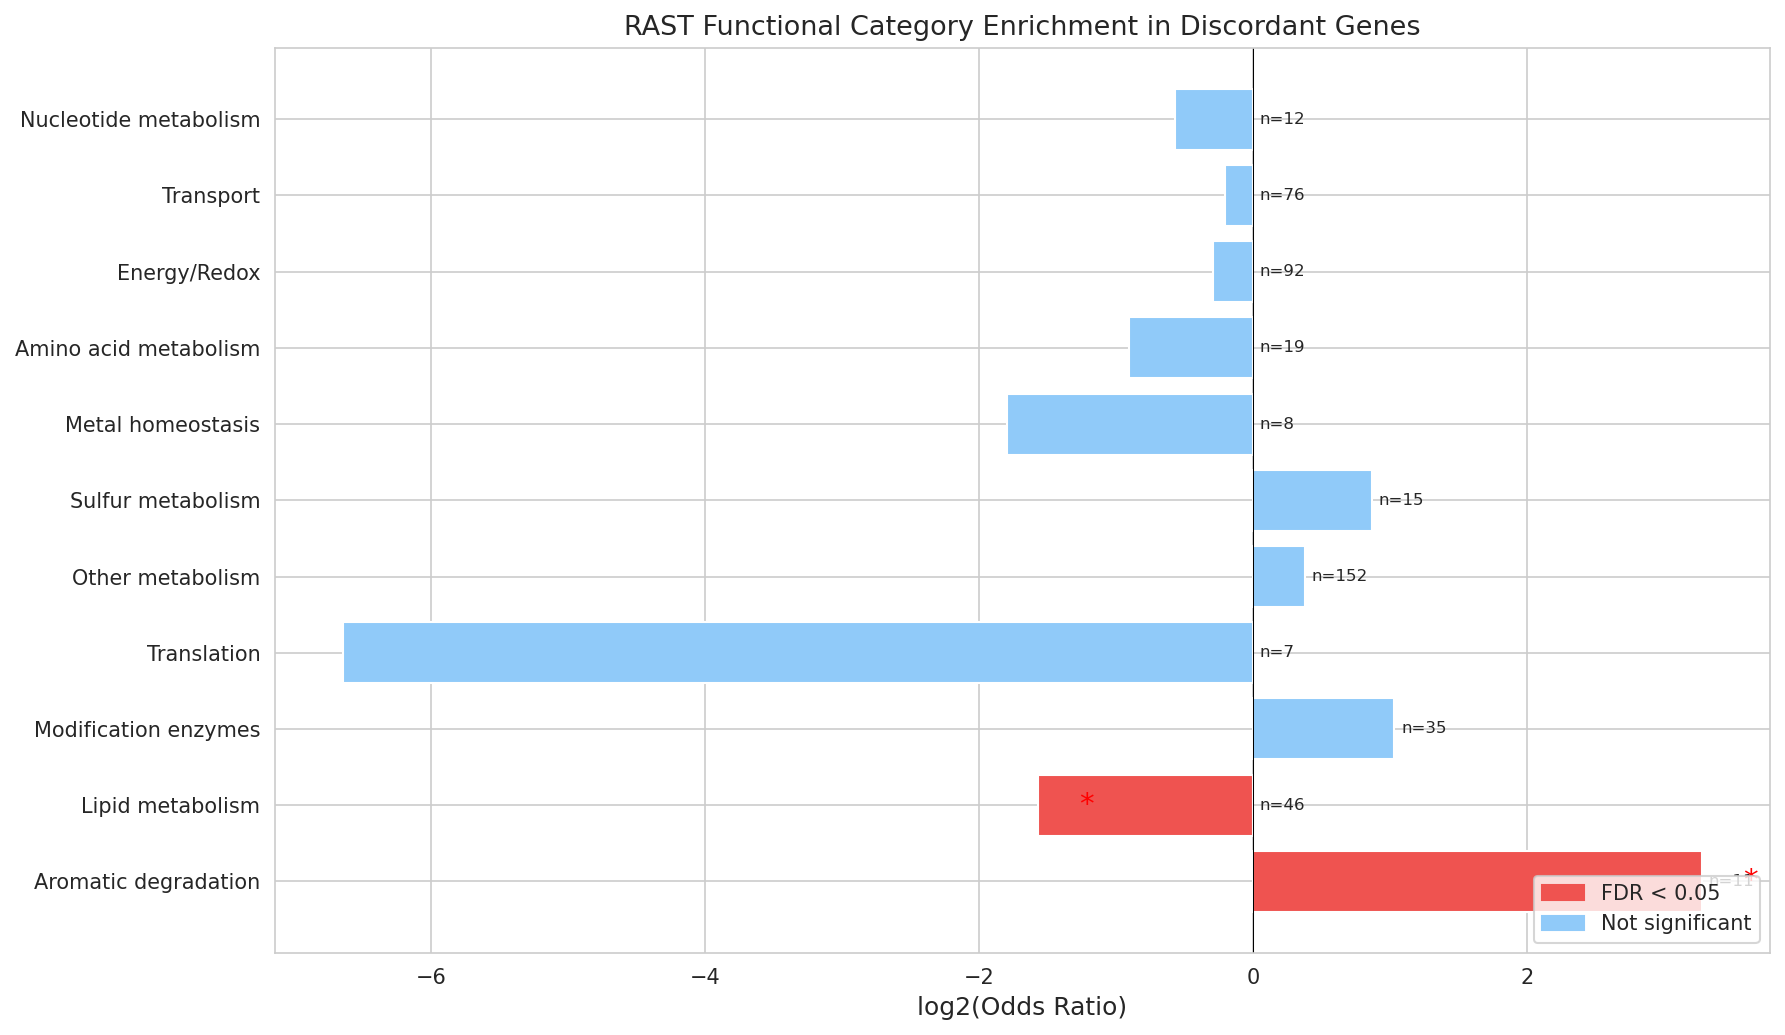

In [6]:
# Visualization: RAST functional category enrichment
fig, ax = plt.subplots(figsize=(12, 7))

plot_df = enrich_df.copy()
plot_df['log2_or'] = np.log2(plot_df['odds_ratio'].clip(lower=0.01))

colors = ['#EF5350' if q < 0.05 else '#90CAF9' for q in plot_df['q_value']]
bars = ax.barh(plot_df['category'], plot_df['log2_or'], color=colors)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('log2(Odds Ratio)', fontsize=12)
ax.set_title('RAST Functional Category Enrichment in Discordant Genes', fontsize=13)

for i, (_, row) in enumerate(plot_df.iterrows()):
    ax.text(max(row['log2_or'], 0) + 0.05, i, f'n={row["total"]:.0f}',
            va='center', fontsize=8)
    if row['q_value'] < 0.05:
        ax.text(row['log2_or'] + 0.3, i, '*', fontsize=14, va='center', color='red')

ax.legend(handles=[
    plt.Rectangle((0,0),1,1, color='#EF5350', label='FDR < 0.05'),
    plt.Rectangle((0,0),1,1, color='#90CAF9', label='Not significant')
], loc='lower right')

plt.tight_layout()
plt.savefig(FIG_DIR / 'rast_enrichment_discordant.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Pangenome Status of Discordant Genes

Are discordant genes more likely to be core or accessory?

In [7]:
# Pangenome status by discordance class
pan_data = triple[triple['pangenome_is_core'].notna()].copy()
pan_data['core'] = pan_data['pangenome_is_core'].astype(bool)

print('Pangenome status by discordance class:')
for cls in ['concordant_essential', 'discordant_over', 'variable_defect',
            'variable_normal', 'discordant_under', 'concordant_blocked']:
    mask = pan_data['discord_class'] == cls
    n_total = mask.sum()
    n_core = (mask & pan_data['core']).sum()
    if n_total > 0:
        print(f'  {cls:<25} {n_core:>3}/{n_total:>3} core ({n_core/n_total*100:5.1f}%)')

# Fisher's exact: discordant vs concordant, core vs accessory
disc_core = (pan_data['is_discordant'] & pan_data['core']).sum()
disc_acc = (pan_data['is_discordant'] & ~pan_data['core']).sum()
conc_core = (~pan_data['is_discordant'] & pan_data['core']).sum()
conc_acc = (~pan_data['is_discordant'] & ~pan_data['core']).sum()
odds_pan, p_pan = stats.fisher_exact([[disc_core, disc_acc], [conc_core, conc_acc]])
print(f'\nFisher exact (discordant core enrichment): OR={odds_pan:.2f}, p={p_pan:.4f}')

Pangenome status by discordance class:
  concordant_essential       56/ 57 core ( 98.2%)
  discordant_over            21/ 21 core (100.0%)
  variable_defect           146/150 core ( 97.3%)
  variable_normal            52/ 54 core ( 96.3%)
  discordant_under          129/135 core ( 95.6%)
  concordant_blocked         56/ 60 core ( 93.3%)

Fisher exact (discordant core enrichment): OR=0.89, p=0.7971


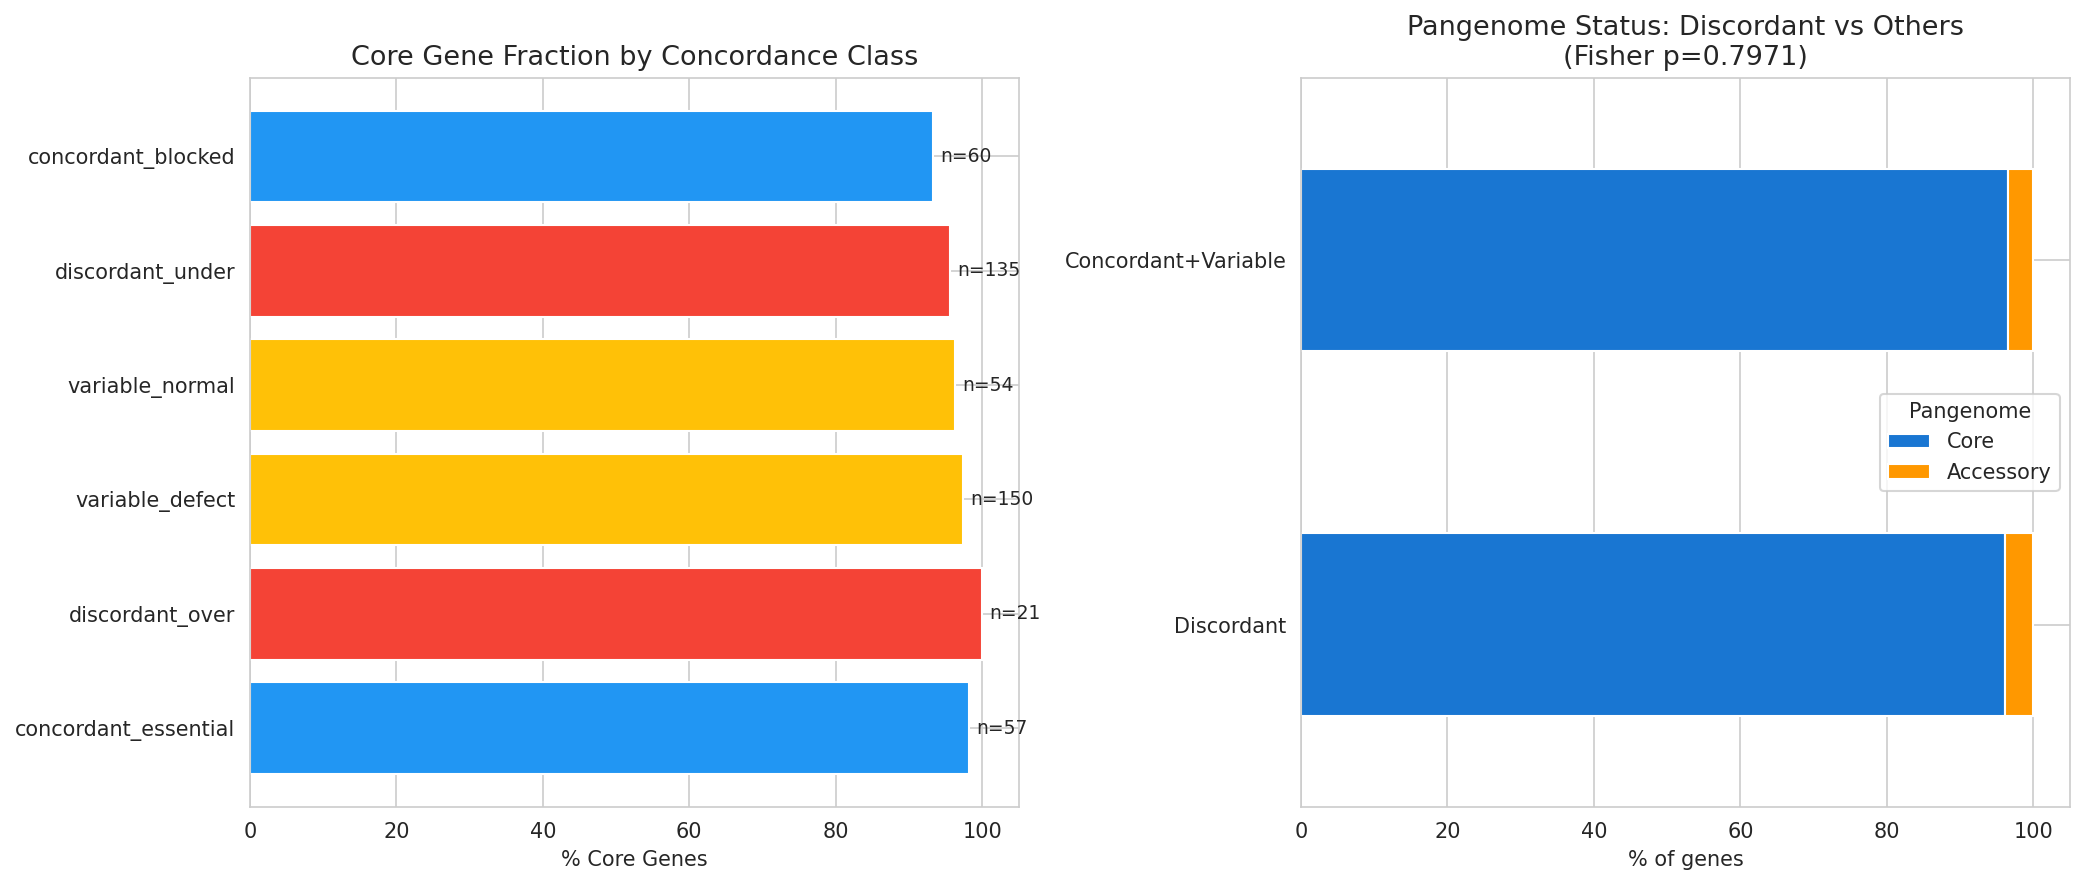

In [8]:
# Visualization: pangenome status by discordance class
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Core fraction by class
class_order = ['concordant_essential', 'discordant_over', 'variable_defect',
               'variable_normal', 'discordant_under', 'concordant_blocked']
core_rates = []
for cls in class_order:
    mask = pan_data['discord_class'] == cls
    n = mask.sum()
    if n > 0:
        core_rates.append({
            'class': cls,
            'core_pct': (mask & pan_data['core']).sum() / n * 100,
            'n': n
        })

core_df = pd.DataFrame(core_rates)
colors_bar = ['#2196F3' if 'concordant' in c else '#F44336' if 'discordant' in c else '#FFC107'
              for c in core_df['class']]
bars = axes[0].barh(core_df['class'], core_df['core_pct'], color=colors_bar)
axes[0].set_xlabel('% Core Genes')
axes[0].set_title('Core Gene Fraction by Concordance Class', fontsize=13)
for i, (_, row) in enumerate(core_df.iterrows()):
    axes[0].text(row['core_pct'] + 1, i, f'n={row["n"]:.0f}', va='center', fontsize=9)

# Panel 2: Stacked bar: discordant vs concordant
summary = pd.DataFrame({
    'Discordant': [disc_core, disc_acc],
    'Concordant+Variable': [conc_core, conc_acc]
}, index=['Core', 'Accessory'])
summary_pct = summary.div(summary.sum()) * 100
summary_pct.T.plot(kind='barh', stacked=True, ax=axes[1],
                    color=['#1976D2', '#FF9800'])
axes[1].set_xlabel('% of genes')
axes[1].set_title(f'Pangenome Status: Discordant vs Others\n(Fisher p={p_pan:.4f})', fontsize=13)
axes[1].legend(title='Pangenome')

plt.tight_layout()
plt.savefig(FIG_DIR / 'pangenome_discordance.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Functional Annotation of Discordant Genes

Examine RAST function and KEGG annotations for discordant genes.

In [9]:
# Top RAST functions in discordant genes
for disc_type, label in [('discordant_over', 'FBA over-predicts'),
                          ('discordant_under', 'FBA under-predicts')]:
    disc = triple[triple['discord_class'] == disc_type]
    funcs = disc['rast_function'].dropna().value_counts().head(15)
    print(f'\nTop RAST functions — {label} (n={len(disc)}):')
    for func, count in funcs.items():
        print(f'  {count:>3}  {func[:80]}')


Top RAST functions — FBA over-predicts (n=21):
    2  Multimodular transpeptidase-transglycosylase (EC 2.4.1.129) (EC 3.4.-.-)
    2  Cardiolipin synthase (EC 2.7.8.-) phosphatidylethanolamine-utilizing, bacterial 
    2  Undecaprenyl-diphosphatase (EC 3.6.1.27)
    1  (2E,6E)-farnesyl diphosphate synthase (EC 2.5.1.10)
    1  Phosphoribosylglycinamide formyltransferase (EC 2.1.2.2)
    1  Cytosine/purine/uracil/thiamine/allantoin permease family protein
    1  N-succinyl-L,L-diaminopimelate aminotransferase (EC 2.6.1.17), type 2
    1  Lysophospholipase (EC 3.1.1.5)
    1  2-keto-3-deoxy-D-arabino-heptulosonate-7-phosphate synthase I alpha (EC 2.5.1.54
    1  Nucleoside:H+ symporter:Major facilitator superfamily
    1  4-hydroxybenzoate transporter
    1  Phosphatidate cytidylyltransferase (EC 2.7.7.41)
    1  Serine acetyltransferase (EC 2.3.1.30)
    1  Phosphoserine phosphatase (EC 3.1.3.3)
    1  Isocitrate dehydrogenase [NADP] (EC 1.1.1.42)

Top RAST functions — FBA under-predic

In [10]:
# KEGG ortholog analysis
ko_data = triple[triple['ko'].notna()].copy()
print(f'Genes with KO annotation: {len(ko_data)}/{len(triple)}')

# Count KOs per discordance class
for cls in ['discordant_over', 'discordant_under', 'concordant_essential', 'concordant_blocked']:
    subset = ko_data[ko_data['discord_class'] == cls]
    n_ko = len(subset)
    n_unique = subset['ko'].nunique()
    print(f'  {cls:<25}: {n_ko} genes, {n_unique} unique KOs')

Genes with KO annotation: 407/478
  discordant_over          : 17 genes, 15 unique KOs
  discordant_under         : 119 genes, 109 unique KOs
  concordant_essential     : 51 genes, 46 unique KOs
  concordant_blocked       : 47 genes, 42 unique KOs


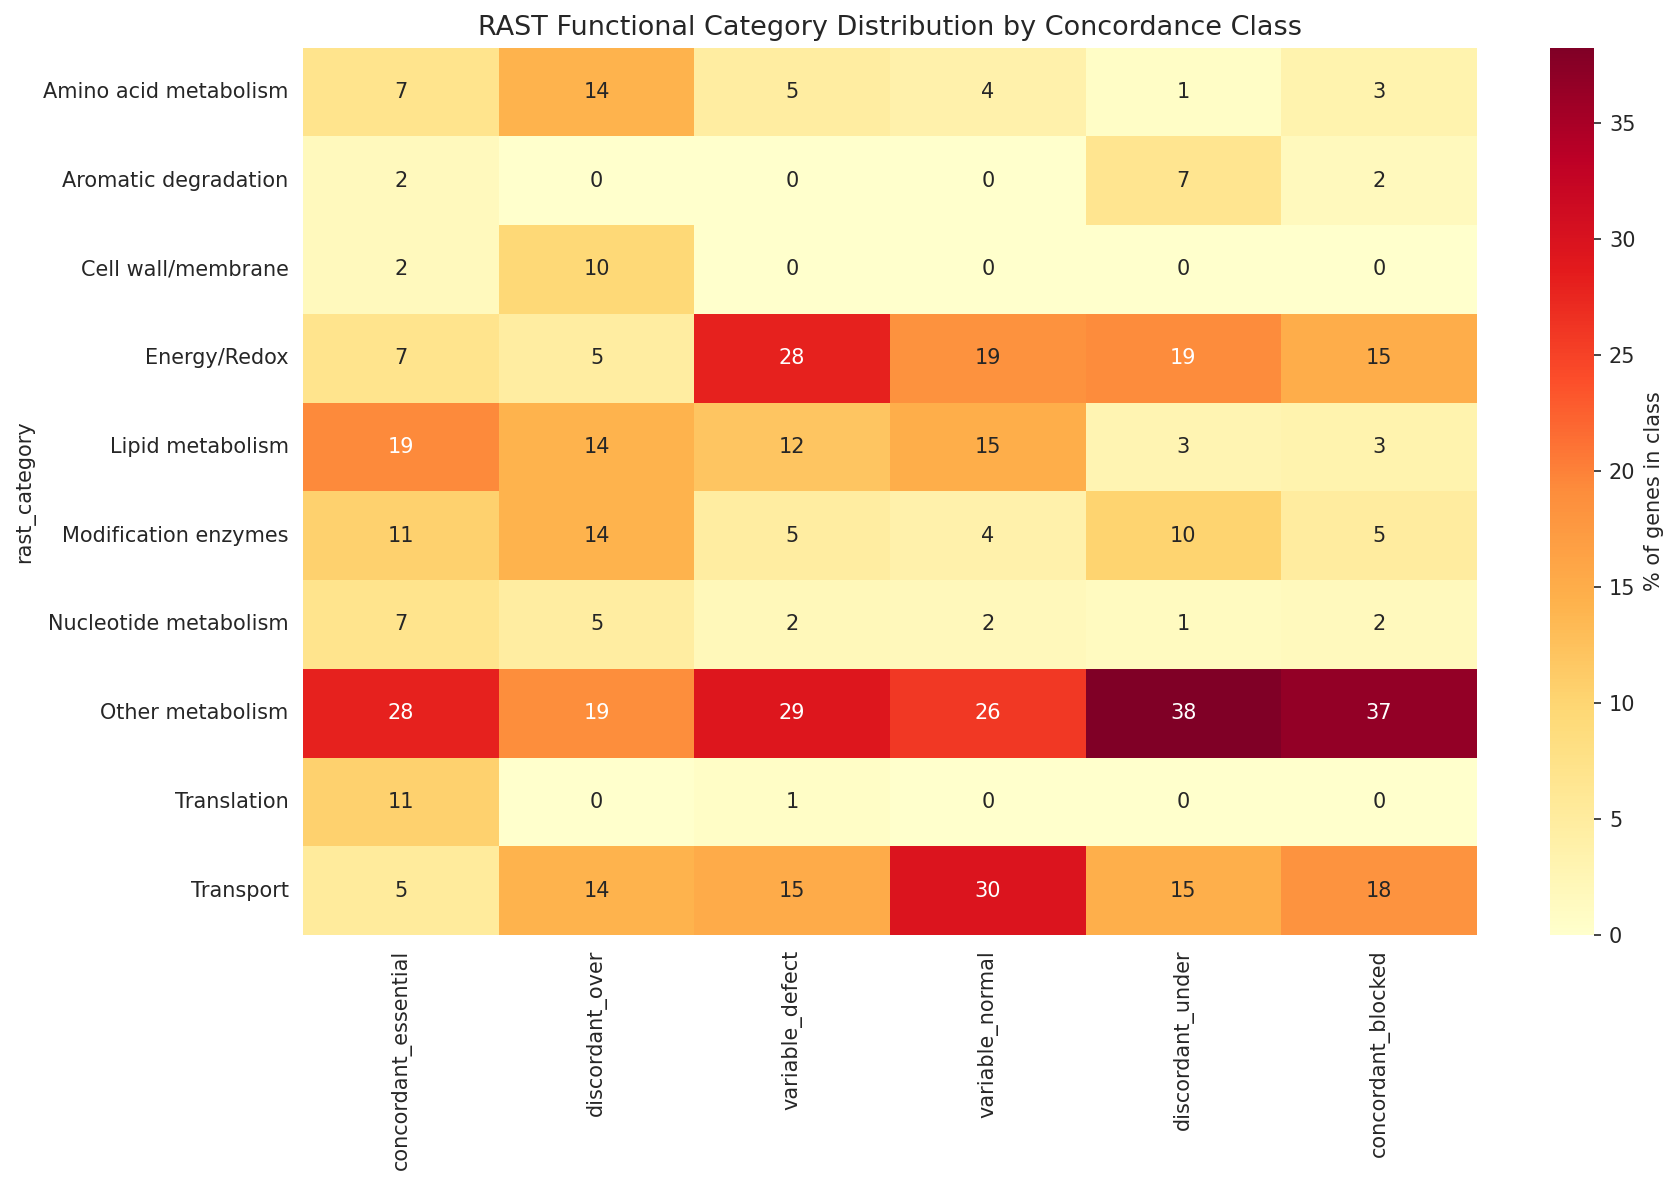

In [11]:
# Heatmap: discordance class composition by RAST functional category
rast_class_matrix = pd.DataFrame()
for cls in class_order:
    cls_genes = triple[triple['discord_class'] == cls]
    n_genes = len(cls_genes)
    cat_counts = cls_genes['rast_category'].value_counts()
    rast_class_matrix[cls] = (cat_counts / n_genes * 100)

rast_class_matrix = rast_class_matrix.fillna(0)
# Only show categories with >5% in at least one class
keep_cats = rast_class_matrix.index[rast_class_matrix.max(axis=1) > 5]
plot_matrix = rast_class_matrix.loc[keep_cats].sort_index()

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(plot_matrix, annot=True, fmt='.0f', cmap='YlOrRd',
            ax=ax, cbar_kws={'label': '% of genes in class'})
ax.set_title('RAST Functional Category Distribution by Concordance Class', fontsize=13)
plt.tight_layout()
plt.savefig(FIG_DIR / 'rast_by_discordance_class.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Summary

In [12]:
print('='*60)
print('DISCORDANT GENE CHARACTERIZATION SUMMARY')
print('='*60)

n_disc = triple['is_discordant'].sum()
n_over = (triple['discord_class'] == 'discordant_over').sum()
n_under = (triple['discord_class'] == 'discordant_under').sum()

print(f'\nTotal discordant genes: {n_disc}/{len(triple)} ({n_disc/len(triple)*100:.1f}%)')
print(f'  FBA over-predicts (essential+normal): {n_over}')
print(f'  FBA under-predicts (blocked+defect): {n_under}')

print(f'\nRAST functional category enrichment:')
sig_cats = enrich_df[enrich_df['q_value'] < 0.05]
if len(sig_cats) > 0:
    for _, row in sig_cats.iterrows():
        direction = 'enriched' if row['odds_ratio'] > 1 else 'depleted'
        print(f'  {row["category"]}: '
              f'{direction} (OR={row["odds_ratio"]:.2f}, q={row["q_value"]:.3f})')
else:
    print('  No functional categories significantly enriched (FDR < 0.05)')

print(f'\nPangenome:')
print(f'  Discordant core enrichment: OR={odds_pan:.2f}, p={p_pan:.4f}')

print(f'\nAnnotation coverage:')
print(f'  RAST function: {triple["rast_function"].notna().sum()}/{len(triple)} (100%)')
print(f'  KO: {triple["ko"].notna().sum()}/{len(triple)} ({triple["ko"].notna().mean()*100:.0f}%)')
print(f'  COG ID (not used — IDs, not categories): {triple["cog"].notna().sum()}/{len(triple)}')

DISCORDANT GENE CHARACTERIZATION SUMMARY

Total discordant genes: 157/478 (32.8%)
  FBA over-predicts (essential+normal): 21
  FBA under-predicts (blocked+defect): 136

RAST functional category enrichment:
  Aromatic degradation: enriched (OR=9.70, q=0.012)
  Lipid metabolism: depleted (OR=0.34, q=0.042)

Pangenome:
  Discordant core enrichment: OR=0.89, p=0.7971

Annotation coverage:
  RAST function: 478/478 (100%)
  KO: 407/478 (85%)
  COG ID (not used — IDs, not categories): 62/478
